In [3]:
using Turing
using Distributions
using DataFrames
using Random
using Plots
using StatsPlots


# Set a seed for reproducibility
Random.seed!(123)

# Generate realistic sample data
n_samples = 1000

# Feature 1: Team Strength (Normally distributed)
team_strength = randn(n_samples) * 2 # Mean 0, std dev 2

# Feature 2: Home Advantage (Binary: 0 or 1)
home_advantage = rand([0, 1], n_samples)

# Feature 3: Odds (Power-law distributed, adjusted based on team strength and home advantage)
odds = zeros(n_samples)
for i in 1:n_samples
    base_odds = 2.0 + abs(team_strength[i]) * 0.5 # Base odds influenced by team strength
    if home_advantage[i] == 1
        base_odds *= 0.8 # Home advantage reduces odds (makes winning more likely)
    end
    odds[i] = rand(Pareto(1.5, base_odds)) # Pareto with scale influenced by base odds
    # Cap odds to avoid extremely high values
    odds[i] = min(odds[i], 20.0)
end


# Target variable: Win (Binary: 0 or 1)
win = zeros(Int, n_samples)
for i in 1:n_samples
    win_prob = 1 / odds[i] # Probability of winning based on odds
    win[i] = rand() < win_prob ? 1 : 0 # Simulate win/loss
end

df = DataFrame(TeamStrength = team_strength, HomeAdvantage = home_advantage, Odds = odds, Win = win)

Row,TeamStrength,HomeAdvantage,Odds,Win
,Float64,Int64,Float64,Int64
1,1.61658,1,2.8243,0
2,-2.24415,0,5.29207,0
3,-2.20927,1,14.5993,0
4,-0.833985,1,7.62948,0
5,0.575176,1,7.24544,0
6,0.459637,1,2.25746,0
7,-0.843537,1,3.79254,0
8,-2.71118,0,3.77439,1
9,0.138918,0,2.4291,0


┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (5000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 3.01 seconds
Compute duration  = 3.01 seconds
parameters        = β_strength, β_home, α
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

  β_strength   -0.1398    0.0183    0.0051    17.6056    21.3415    1.1059     ⋯
      β_home    0.4913    0.0026    0.0005    24.4869    25.0055    1.0996     ⋯
           α    1.0045    0.0040    0.0004    67.2320    33.9615    1.0048     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0

Probability of win: 0.37641064058421264


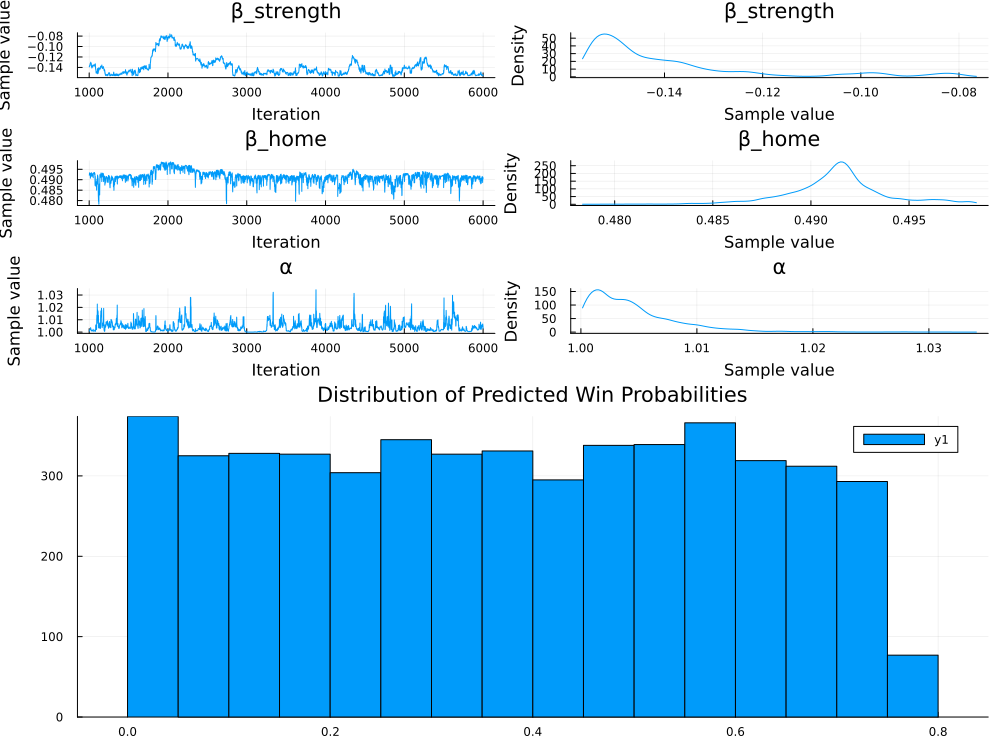

In [4]:
# Turing model (same as before)
@model function betting_model(team_strength, home_advantage, odds, win)
    # Priors
    β_strength ~ Normal(0, 1) # Effect of team strength
    β_home ~ Normal(0, 1) # Effect of home advantage
    α ~ truncated(Pareto(1, 1), lower = 1.0) #Shape parameter for the pareto distribution

    # Likelihood
    for i in 1:length(win)
        # Model for base odds (before Pareto)
        base_odds = exp(β_strength * team_strength[i] + β_home * home_advantage[i])
        odds[i] ~ Pareto(α, base_odds)

        # Model for win probability (using the simulated odds)
        win_prob = 1 / odds[i]
        win[i] ~ Bernoulli(win_prob)
    end
    return β_strength, β_home, α
end

# Create and sample the model
model = betting_model(df.TeamStrength, df.HomeAdvantage, df.Odds, df.Win)
chain = sample(model, NUTS(0.65), 5000) # Increased samples for better convergence

display(chain)

p1 = plot(chain) # Plots the chains to assess convergence
# savefig("chains.png")

# Prediction using generated quantities
function predict_win_probability(chain, new_team_strength, new_home_advantage)
    n_samples = length(chain)
    win_probs = zeros(n_samples)
    for i in 1:n_samples
        β_strength_i = chain[:β_strength][i]
        β_home_i = chain[:β_home][i]
        α_i = chain[:α][i]

        base_odds = exp(β_strength_i * new_team_strength + β_home_i * new_home_advantage)
        odds_new = rand(Pareto(α_i, base_odds))
        win_probs[i] = 1 / odds_new
    end
    return win_probs
end

new_team_strength = 1.5
new_home_advantage = 1
win_probabilities = predict_win_probability(chain, new_team_strength, new_home_advantage)
println("Probability of win: ", mean(win_probabilities))
p2 = histogram(win_probabilities, title="Distribution of Predicted Win Probabilities")
# savefig("win_probs_hist.png")

display(plot(p1, p2, layout = (2, 1)))